one hot encoding vector size is  12
epochs : 0
50/50 - 2s - loss: 2.3680 - accuracy: 0.2600
epochs : 1
50/50 - 0s - loss: 2.0355 - accuracy: 0.3400
epochs : 2
50/50 - 0s - loss: 1.9614 - accuracy: 0.3400
epochs : 3
50/50 - 0s - loss: 1.9432 - accuracy: 0.3400
epochs : 4
50/50 - 0s - loss: 1.9311 - accuracy: 0.3400
epochs : 5
50/50 - 0s - loss: 1.9226 - accuracy: 0.3400
epochs : 6
50/50 - 0s - loss: 1.9158 - accuracy: 0.3400
epochs : 7
50/50 - 0s - loss: 1.9099 - accuracy: 0.3400
epochs : 8
50/50 - 0s - loss: 1.9046 - accuracy: 0.3400
epochs : 9
50/50 - 0s - loss: 1.8992 - accuracy: 0.3400
epochs : 10
50/50 - 0s - loss: 1.8934 - accuracy: 0.3400
epochs : 11
50/50 - 0s - loss: 1.8866 - accuracy: 0.3600
epochs : 12
50/50 - 0s - loss: 1.8775 - accuracy: 0.3600
epochs : 13
50/50 - 0s - loss: 1.8646 - accuracy: 0.3600
epochs : 14
50/50 - 0s - loss: 1.8556 - accuracy: 0.3800
epochs : 15
50/50 - 0s - loss: 1.8267 - accuracy: 0.3600
epochs : 16
50/50 - 0s - loss: 1.8835 - accuracy: 0.3400
epoch

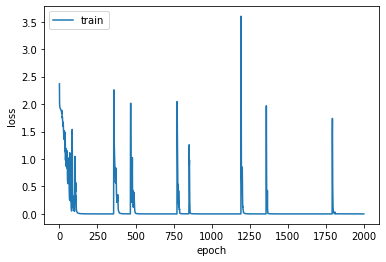

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

from functions import LossHistory
from functions import print_learning

np.random.seed(5)

# 데이터셋 생성
def seq2dataset(seq, window_size):
    dataset_X = []
    dataset_Y = []

    for i in range(len(seq)-window_size):

        subset = seq[i:(i+window_size+1)]

        for si in range(len(subset)-1):
            features = code2features(subset[si])
            dataset_X.append(features)

        dataset_Y.append([code2idx[subset[window_size]]])

    return np.array(dataset_X), np.array(dataset_Y)

# 속성 변환 함수
def code2features(code):
    features = []
    features.append(code2scale[code[0]]/float(max_scale_value))
    features.append(code2length[code[1]])
    return features

# 사전정
code2scale = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'a':5, 'b':6}
code2length = {'4':0, '8':1}

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

max_scale_value = 6.0

# 시퀀스 데이터
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

x_train, y_train = seq2dataset(seq, window_size = 4)

# 형태 변환 (샘플 수, 타입스텝, 특성 수)
x_train = np.reshape(x_train, (50, 4, 2))

# 라벨 one-hot 인코딩
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 모델 구성
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 2), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 모델 학습과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 학습
num_epochs = 2000

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()

print_learning(history)

# 모델 평가
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

In [3]:
pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

print("one step prediction : ", seq_out)

model.reset_states()

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in

seq_in_featrues = []

for si in seq_in:
    features = code2features(si)
    seq_in_featrues.append(features)

for i in range(pred_count):
    sample_in = np.array(seq_in_featrues)
    sample_in = np.reshape(sample_in, (1, 4, 2)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])

    features = code2features(idx2code[idx])
    seq_in_featrues.append(features)
    seq_in_featrues.pop(0)

model.reset_states()

print("full song prediction : ", seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
